# VAERS data reveals no increased risk of neuroautoimmune association from COVID-19 vaccines

This notebook contains the calculations that underlie the above paper.


## Data preprocessing

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from matplotlib import pyplot as plt
import seaborn as sns
from helpers.ingest_vaers import ingest
import warnings

warnings.filterwarnings('ignore')

In [2]:
vaers_data = ingest(2021, 2020, 2019, 2018, 2017, 2016, 2015, path="data/")

In [3]:
vaers_data = vaers_data[["VAERS_ID", "SYMPTOM", "VAX_TYPE", "AGE_YRS", "SEX"]]

NEUR_SYMPTOMS = ("Demyelinating polyneuropathy",
                 "Immune-mediated neuropathy",
                 "Axonal neuropathy",
                 "Axonal and demyelinating neuropathy",
                 "Chronic inflammatory demyelinating polyradiculoneuropathy",
                 "Subacute inflammatory demyelinating polyradiculoneuropathy",
                 "Autoimmune neuropathy",
                 "Autonomic neuropathy",
                 "Guillain-Barre syndrome",
                 "Acute disseminated encephalomyelitis",
                 "Demyelinating polyneuropathy",
                 "Neuromyelitis optica spectrum disorder",
                 "Neuromyelitis optica",
                 "Myelitis transverse",
                 "Multiple sclerosis relapse",
                 "Multiple sclerosis",
                 "Relapsing multiple sclerosis",
                 "Progressive multiple sclerosis",
                 "Relapsing-remitting multiple sclerosis",
                 "Optic neuritis",
                 "Immune-mediated encephalitis",
                 "Autoimmune encephalopathy",
                 "Encephalitis autoimmune",
                 "Autoimmune demyelinating disease")

vaers_data["IS_COVID_VACCINE"] = (vaers_data.VAX_TYPE == "COVID19").astype(int)
vaers_data["IS_NEUROINFLAMMATORY"] = vaers_data["SYMPTOM"].isin(NEUR_SYMPTOMS).astype(int)

## Creating vaccine type level contingency table

In [18]:
df = vaers_data[["VAX_TYPE", "IS_NEUROINFLAMMATORY"]]
xt = pd.crosstab(df.VAX_TYPE, df.IS_NEUROINFLAMMATORY).rename(columns={0: "No", 1: "Yes"})

In [19]:
xt

IS_NEUROINFLAMMATORY,No,Yes
VAX_TYPE,,
6VAX-F,218,0
ADEN,2,0
ADEN_4_7,457,11
ANTH,5724,10
BCG,101,0
...,...,...
TYP,7704,11
UNK,22373,38
VARCEL,51735,25


In [63]:
odds_ratios = pd.DataFrame(columns=["OR", "CI_lower_bound", "CI_upper_bound"], index=xt.index)

for idx, row in enumerate(xt.index):
    a = xt.loc[row]["Yes"].sum()
    b = xt.loc[row]["No"].sum()
    c = xt.drop(row, axis=0)["Yes"].sum()
    d = xt.drop(row, axis=0)["No"].sum()
    SE = np.sqrt(1/a + 1/b + 1/c + 1/d)
    OR = (a*d)/(c*b)
    odds_ratios["OR"].loc[row] = OR
    odds_ratios["CI_lower_bound"].loc[row] = np.e ** (np.log(OR) - 1.96 * SE)
    odds_ratios["CI_upper_bound"].loc[row] = np.e ** (np.log(OR) + 1.96 * SE)


,Vaccine type,variable,value
0,6VAX-F,OR,0.0
1,EBZR,OR,0.0
2,RV,OR,0.0
3,RUB,OR,0.0
4,PNC10,OR,0.0
...,...,...,...
271,FLU(H1N1),CI_upper_bound,50.13833
272,ADEN_4_7,CI_upper_bound,44.12151
273,FLUN3,CI_upper_bound,39.449787
274,FLUN(H1N1),CI_upper_bound,105.759081


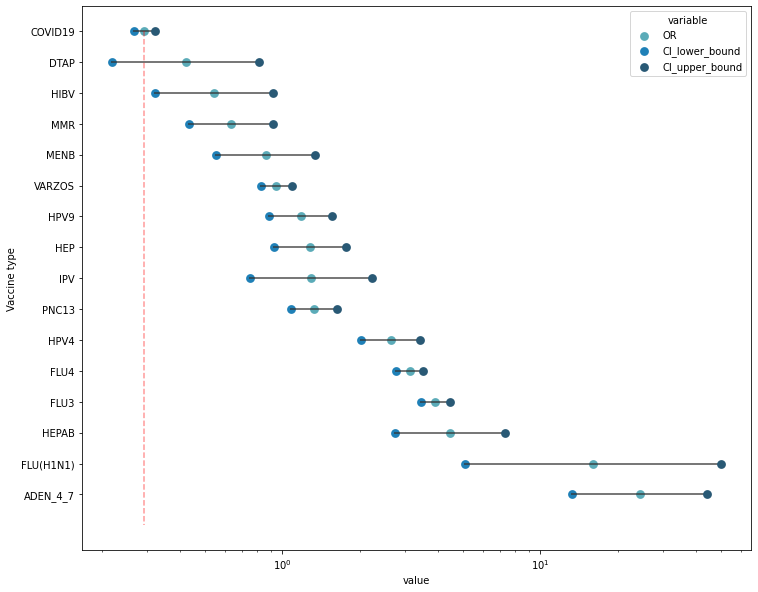

In [126]:
SHOW_VACCINES = ()

odds_ratios_filtered = odds_ratios.loc[["COVID19", "DTAP", "HIBV", "MMR", "MENB", "HPV4", "HPV9", "FLU3", "FLU4", "IPV", "HEP", "VARZOS", "PNC13", "HEPAB", "ADEN_4_7", "FLU(H1N1)"]].sort_values("OR")
odds_ratios_filtered["Vaccine type"] = odds_ratios_filtered.index

f, ax = plt.subplots(figsize=(12, 10))
ax.set_xscale("log")

for idx, val in enumerate(odds_ratios_filtered.index):
    plt.plot([odds_ratios_filtered.iloc[idx]["CI_lower_bound"], odds_ratios_filtered.iloc[idx]["CI_upper_bound"]], [idx, idx], linewidth=2, alpha = 0.66, color="#333")

grid = sns.pointplot(x = "value",
              y = "Vaccine type",
              hue = "variable",
              join = False,
              jitter = False,
              ci = "sd",
              err_style = "bars",
              palette="YlGnBu_d",
              data = odds_ratios_filtered.melt(id_vars=["Vaccine type"], value_vars=["OR", "CI_lower_bound", "CI_upper_bound"]))

plt.plot([odds_ratios_filtered.loc["COVID19"]["OR"], odds_ratios_filtered.loc["COVID19"]["OR"]],
         [0, len(odds_ratios_filtered.index)],
         "r--",
         alpha = 0.4,)


In [111]:
odds_ratios_filtered

,OR,CI_lower_bound,CI_upper_bound,Vaccine type
VAX_TYPE,,,,
COVID19,0.291921,0.266506,0.31976,COVID19
DTAP,0.421676,0.219114,0.811495,DTAP
HIBV,0.541793,0.320361,0.916279,HIBV
MMR,0.63292,0.436045,0.918686,MMR
MENB,0.862181,0.55516,1.338993,MENB
VARZOS,0.946003,0.823273,1.087029,VARZOS
HPV9,1.17648,0.886565,1.561199,HPV9
HEP,1.278334,0.927721,1.761453,HEP
IPV,1.293237,0.7496,2.23114,IPV
